In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys

In [2]:
def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix 
    
    # IMPLEMENT THIS METHOD
    
    class_list = np.unique(y)  # Creating a unique class list with size of 1 * d
    
    # Create an empty d * k matrix for means
    means = np.zeros((X.shape[1], class_list.shape[0]))
    
    # Put all the mean column vector into means matrix
    j = 0
    for i in class_list:     # Iterate the class list
        location = np.where(y == i)[0]   # Find row indexes for a specific class
        mean = np.mean(X[location], axis=0)
        means[:, j] = mean.transpose()
        j = j + 1

    # Calculate the mean of every column for means matrix
    ground_mean = np.mean(X, axis=0)

    # Calculate the covariance matrix of X
    covmat = np.cov((X - ground_mean).transpose())
    
    return means,covmat


In [3]:
def qdaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes
    
    # IMPLEMENT THIS METHOD
    
    class_list = np.unique(y)  # Creating a unique class list

    # Create an empty d*k matrix for means. And it is the same as LDA
    means = np.zeros((X.shape[1], class_list.shape[0]))

    j = 0
    covmats = []

    for i in class_list.transpose():
        location2 = np.where(y == i)[0]
        mean2 = np.mean(X[location2], axis=0)
        means[:, j] = mean2.transpose()
        dif = X[location2, ] - mean2
        covmats.append(np.cov(dif.transpose()))
        j = j + 1

    return means,covmats

In [4]:
def ldaTest(means,covmat,Xtest,ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    
    # Create a new empty matrix with N*k size
    result_p = np.zeros((Xtest.shape[0], means.shape[1]))

    # prior probability
    p = 1/np.sqrt((2*pi) ** means.shape[0] * det(covmat))

    # Calculate probabilities of every Xi for every y
    j = 0
    for i in means.transpose():
        mean = i
        Prob = p * np.exp(- 0.5 * np.sum([a * b for a, b in zip(np.dot(Xtest - mean, inv(covmat)), Xtest - mean)], axis=1))
        result_p[:, j] = Prob
        j = j + 1

    ypred = np.argmax(result_p, axis=1) + 1
    error = ypred - ytest.ravel()
    acc = (Xtest.shape[0] - float(len(np.nonzero(error)[0])))/Xtest.shape[0]

    return acc,ypred

In [5]:
def qdaTest(means,covmats,Xtest,ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    
    # Create a new empty matrix with N*k size
    result_p2 = np.zeros((Xtest.shape[0], means.shape[1]))

    j = 0
    for i in means.transpose():
        p = 1 / np.sqrt((2*pi) ** means.shape[0] * det(covmats[j]))
        mean = i

        Prob = p * np.exp(- 0.5 * np.sum([a * b for a, b in zip(np.dot(Xtest - mean, inv(covmats[j])), Xtest - mean)], axis=1))

        result_p2[:, j] = Prob
        j = j + 1

    ypred = np.argmax(result_p2, axis=1) + 1
    error = ypred - ytest.ravel()
    acc = (Xtest.shape[0] - float(len(np.nonzero(error)[0]))) / Xtest.shape[0]
    
    return acc,ypred

In [6]:
def learnOLERegression(X,y):
    # Inputs:                                                         
    # X = N x d 
    # y = N x 1                                                               
    # Output: 
    # w = d x 1 
	
    # IMPLEMENT THIS METHOD
    
    w = np.dot(np.dot(inv(np.dot(X.transpose(), X)), X.transpose()), y)
    return w

In [7]:
def learnRidgeRegression(X,y,lambd):
    # Inputs:
    # X = N x d                                                               
    # y = N x 1 
    # lambd = ridge parameter (scalar)
    # Output:                                                                  
    # w = d x 1                                                                

    # IMPLEMENT THIS METHOD 
#     k = inv(lambd * np.identity(X.shape[1]) + np.dot(X.transpose(), X))
#     w = np.dot(np.dot(k, X.transpose()), y)
    
    Xt_X = np.dot(np.transpose(X), X)
    LI = lambd*np.eye(Xt_X.shape[0])
    w = np.dot(inv(Xt_X+LI), np.dot(np.transpose(X), y))
    return w

In [8]:
def testOLERegression(w,Xtest,ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # mse
    
    # IMPLEMENT THIS METHOD
    y_predict = np.dot(Xtest,w)
    error = ytest - y_predict
    mse = np.sum(np.dot(error.transpose(), error)) / float(Xtest.shape[0])
    
    return mse

In [9]:
def regressionObjVal(w, X, y, lambd):

    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda                                                                  

    # IMPLEMENT THIS METHOD
    
#     extra_term = y - np.dot(X, np.mat(w).transpose())
#     error = 0.5 * np.dot(extra_term.transpose(), extra_term) + 0.5 * lambd * np.dot(np.mat(w).transpose(), np.mat(w))
#     error_grad = np.squeeze(np.array(np.dot(np.dot(inv((np.dot(X.transpose(), X) + lambd)), X.transpose()), y)))
    
    d = X.shape[1]
    w_mat = np.reshape(w,(d,1))
    inter = y - np.dot(X_i,w_mat)
    
    error = 0.5*(np.dot(inter.transpose(),inter) + lambd*np.dot(w_mat.transpose(),w_mat))
    
    # diff the same 
    # -0.5 * xT (y-Xw) + lambda * w
    error_grad = -(np.dot(X_i.transpose(),inter)) + lambd*w_mat
    error_grad = np.squeeze(np.array(error_grad))
    
    return error, error_grad

In [10]:
def mapNonLinear(x,p):
    # Inputs:                                                                  
    # x - a single column vector (N x 1)                                       
    # p - integer (>= 0)                                                       
    # Outputs:                                                                 
    # Xp - (N x (p+1)) 
	
    # IMPLEMENT THIS METHOD
    
    Xp_ = []
    for i in range(0, p+1):
        Xp_.append(x**i)
        Xp = np.mat(Xp_)
    return Xp

In [11]:
# Main script

# Problem 1
# load the sample data                                                                 
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

In [12]:
# LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))

LDA Accuracy = 0.97


In [13]:
# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

QDA Accuracy = 0.96


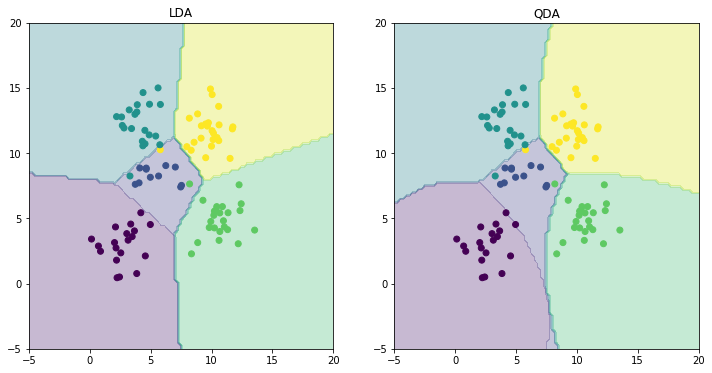

In [14]:
# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0], Xtest[:,1],c=ytest[:,0])
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest[:,0])
plt.title('QDA')

plt.show()

In [15]:
# Problem 2
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)

print('MSE without intercept '+str(mle))
print('MSE with intercept '+str(mle_i))

MSE without intercept 106775.36155731279
MSE with intercept 3707.8401814549306


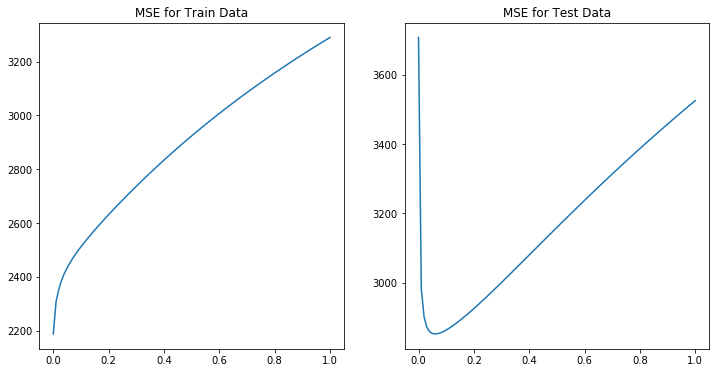

In [16]:
# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')

plt.show()

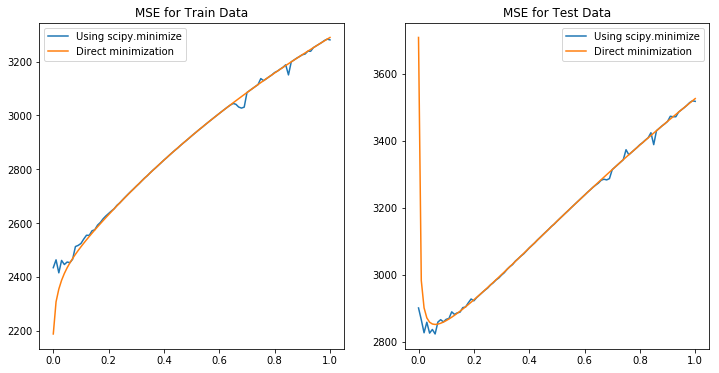

In [17]:
# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.                                                
w_init = np.ones((X_i.shape[1],1))
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()

In [18]:
# Problem 5
pmax = 7
lambda_opt = 0 # REPLACE THIS WITH lambda_opt estimated from Problem 3
mses5_train = np.zeros((pmax,2))
mses5 = np.zeros((pmax,2))
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0)
    mses5_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    mses5_train[p,1] = testOLERegression(w_d2,Xd,y)
    mses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses5_train)
plt.title('MSE for Train Data')
plt.legend(('No Regularization','Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses5)
plt.title('MSE for Test Data')
plt.legend(('No Regularization','Regularization'))
plt.show()

LinAlgError: Singular matrix